# Imports/Setup

In [1]:
import polars as pl
import numpy as np
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")
import matplotlib.pylab as plt
import cv2
import datashader as ds
import colorcet as cc
from hydra import initialize, compose

## Import Male Right Mesh data

In [2]:
imported_data =\
    np.load("E:\Geodesic-Path-Finder\Data\male right arm mesh data.npz")

# Get the 3D mesh data
mesh_verticies = imported_data["mesh_verticies"]
mesh_faces = imported_data["mesh_faces"]

# Get the uv data
uv_array = imported_data["uv_array"]

# Get the lookup table
lookup_data = pl.from_numpy(imported_data["lookup_data"],
                            schema=["vertex", "uv"])

# Find the Area of the Mesh Faces

## Area of 3D Triangle
- $A = \frac{\mid\mid \vec{AB} \times \vec{AC} \mid\mid}{2}$
- For any triangle with points $A$, $B$, $C$.

In [3]:
def triangle_area(triangle: np.ndarray) -> float:
    '''
    Finds the area of an arbitrary triangle.

    Takes in the three points of any triangle and finds the area using half
    the magnitude of the cross product.

    Parameters
    ----------
    triangle : np.ndarray
        A 3xN array where the rows are the three points and the columns define
        the coordinates of the point in space.

    Returns
    -------
    area : float
        The area of the triangle. 
    '''
    # Extract the points of the triangle
    point_1 = triangle[0, :]
    point_2 = triangle[1, :]
    point_3 = triangle[2, :]

    # triangle vectors
    AB = point_2 - point_1
    AC = point_3 - point_1

    area = np.linalg.norm(np.cross(AB, AC))

    return area

## Make a list of all of the Mesh Face Areas

In [4]:
mesh_areas = []
for face in mesh_faces:
    triangle = np.array([
        mesh_verticies[face[0]],
        mesh_verticies[face[1]],
        mesh_verticies[face[2]]
        ])
    area = triangle_area(triangle)
    mesh_areas.append(area)

<Axes: >

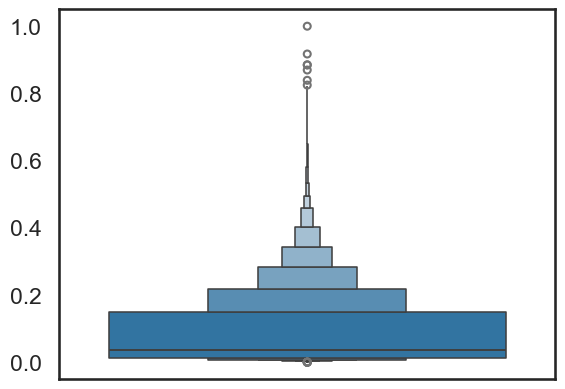

In [5]:
sns.boxenplot(data=mesh_areas / np.max(mesh_areas))

## Find the UV mapp areas

In [6]:
# Load in the text version of the model
mesh_data =\
    pl.read_csv(
        "E:\Geodesic-Path-Finder\Models\Male Right Arm UV Mapped as Text.txt",
        separator=' ', has_header=False,
        new_columns=["Type", "Point 1", "Point 2", "Point 3"],
        infer_schema_length=0)

# Split the input data into groups of v, vt, vn, and f for the
# vertex, UV (texture), Normal, and face data.
grouped_mesh_data = mesh_data.partition_by(["Type"], as_dict=True)

# Get the face data
face_data = grouped_mesh_data[("f",)]
# Split each column into its own table for the vertex, uv and normal
# of each point on a face.
split_face_data_1 = face_data.with_columns(
    pl.col("Point 1")
    .str.split_exact("/", 3)
    .struct.rename_fields(["vertex", "uv", "normal"])
    .alias("fields")
).unnest(
    "fields").drop("Type").drop("Point 1").drop("Point 2").drop("Point 3")
split_face_data_1 = split_face_data_1.with_columns(
    pl.col("vertex").cast(pl.Int32)
    ).with_columns(
        pl.col("uv").cast(pl.UInt32)
    ).drop("normal")

split_face_data_2 = face_data.with_columns(
    pl.col("Point 2")
    .str.split_exact("/", 3)
    .struct.rename_fields(["vertex", "uv", "normal"])
    .alias("fields")
).unnest(
    "fields").drop("Type").drop("Point 1").drop("Point 2").drop("Point 3")
split_face_data_2 = split_face_data_2.with_columns(
    pl.col("vertex").cast(pl.Int32)
    ).with_columns(
        pl.col("uv").cast(pl.UInt32)
    ).drop("normal")

split_face_data_3 = face_data.with_columns(
    pl.col("Point 3")
    .str.split_exact("/", 3)
    .struct.rename_fields(["vertex", "uv", "normal"])
    .alias("fields")
).unnest(
    "fields").drop("Type").drop("Point 1").drop("Point 2").drop("Point 3")
split_face_data_3 = split_face_data_3.with_columns(
    pl.col("vertex").cast(pl.Int32)
    ).with_columns(
        pl.col("uv").cast(pl.UInt32)
    ).drop("normal")

In [7]:
uv_areas = []
for i in range(len(split_face_data_1)):
    uv_1 = uv_array[split_face_data_1["uv"][i]]
    uv_2 = uv_array[split_face_data_2["uv"][i]]
    uv_3 = uv_array[split_face_data_3["uv"][i]]

    triangle = np.array([
        uv_1,
        uv_2,
        uv_3
    ])
    area = triangle_area(triangle)
    if area > 0:
        uv_areas.append(area)

<Axes: >

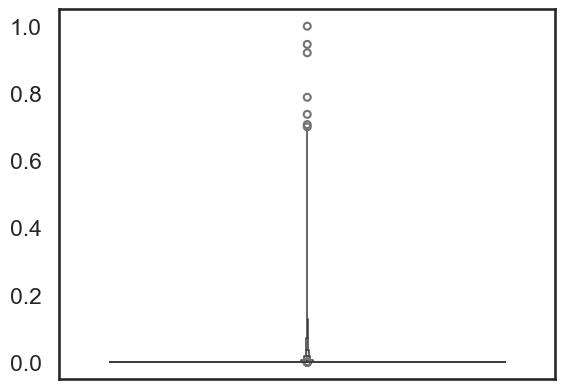

In [8]:
sns.boxenplot(data=uv_areas / np.max(uv_areas))

In [9]:
mesh_areas_table = pl.DataFrame(
    data={"Normalized Area": mesh_areas / np.max(mesh_areas)},
    schema={"Normalized Area": pl.Float64}
    ).with_columns(pl.lit("Mesh Area").alias("Mapping Type"))

uv_areas_table = pl.DataFrame(
    data={"Normalized Area": uv_areas / np.max(uv_areas)},
    schema={"Normalized Area": pl.Float64}
    ).with_columns(pl.lit("2D Mapped Area").alias("Mapping Type"))

area_table = pl.concat([mesh_areas_table, uv_areas_table])

Text(0.5, 1.0, 'Comparison of Mesh Areas to 2D Mapped Areas')

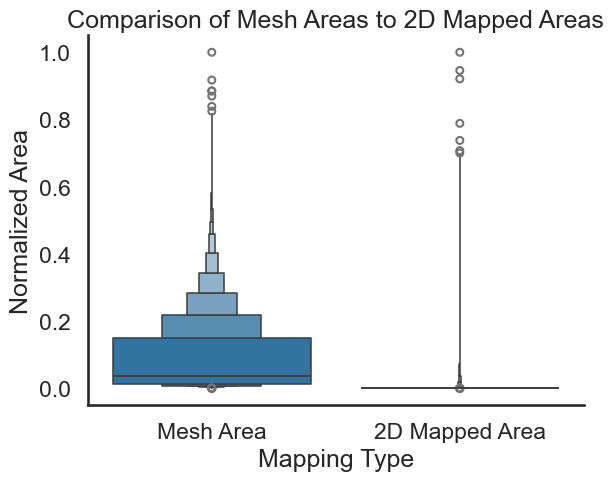

In [10]:
sns.boxenplot(data=area_table.to_pandas(), x="Mapping Type",
              y="Normalized Area")
sns.despine()
plt.title("Comparison of Mesh Areas to 2D Mapped Areas")

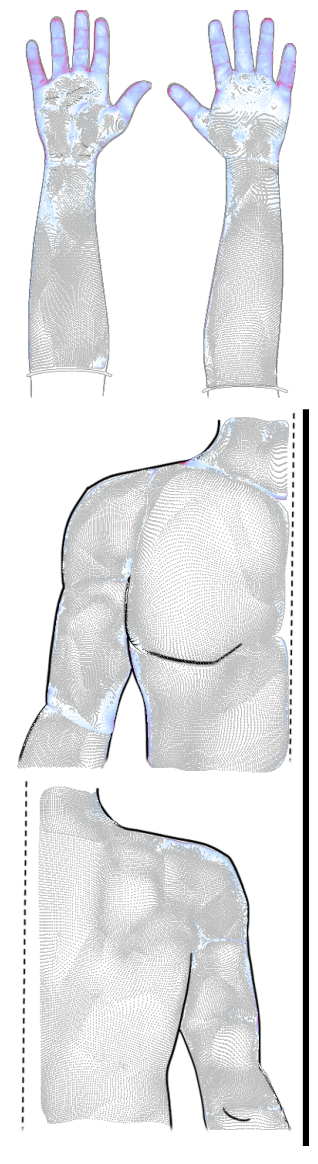

In [11]:
# Find the image dimensions
with initialize(version_base=None, config_path="config"):
    cfg = compose(config_name='config.yaml')
im = cv2.imread(cfg.drawing_templates.image, 1)
image_x_size = im.shape[1]
image_y_size = im.shape[0]
fig = plt.figure(figsize=(image_x_size/500, image_y_size/500))
scale = 5
im = cv2.resize(im, (round(image_x_size / scale), round(image_y_size / scale)))
plt.imshow(im)

uv_data = pl.DataFrame({"U": uv_array[:, 0],
                        "V": uv_array[:, 1]})

scale = 0.97
agg = ds.Canvas(
    plot_width=round(im.shape[1] * scale),
    plot_height=round(im.shape[0] * scale)
    ).points(uv_data.to_pandas(), 'U', 'V')
img = ds.tf.set_background(
    ds.tf.shade(agg, how="log",
                cmap=cc.CET_L19)).to_pil()
x_shift = 10
y_shift = 10
M = np.float32([
	[1, 0, x_shift],
	[0, 1, y_shift]
])
img = np.array(img)
img = cv2.resize(img, (round(img.shape[1] * 0.96),
                       round(img.shape[0] * 1.01)))

shifted = cv2.warpAffine(img, M, (img.shape[1] + x_shift,
                                  img.shape[0] + y_shift))
plt.imshow(shifted)
plt.xlim([0, im.shape[1]])
plt.ylim([im.shape[0] + y_shift, y_shift])
plt.axis('off')
plt.show()